# Clasificador de imagenes utilizando una red neuronal

Ejercicio obtenido de www.tensorflow.org/tutorials/

In [1]:
import tensorflow as tf
from tensorflow import keras

import numpy as np
import matplotlib.pyplot as plt

Vamos a utilizar el dataset Fashion MNIST el cual contiene más de 70,000 imagenes en 10 categorías. Las imagenes muestrasn artículos individuales de ropa a una resolución baja (28x28 píxeles).


### Cargando el data set

In [2]:
fashion_mnist = keras.datasets.fashion_mnist

### Dividiendo los datos

In [3]:
(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

4423680/4422102 [==============================] - 0s 0us/step


In [4]:
# Tendremos 60k imagenes de 28x28 pixeles
train_images.shape

(60000, 28, 28)

In [5]:
# Y 10k para las pruebas
test_images.shape

(10000, 28, 28)

In [6]:
# Verificamos los valores que tienen nuestras etiquetas
train_labels

array([9, 0, 0, ..., 3, 0, 5], dtype=uint8)

### Etiquetas

In [7]:
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

### Pre-processing del set de datos

El set de datos debe ser pre-procesado antes de entrenar a la red. Si inspeccionamos alguna de las imagenes del set de entrenamiento nos vamos a percatar de que los valores de los píxeles están entre 0 y 255:


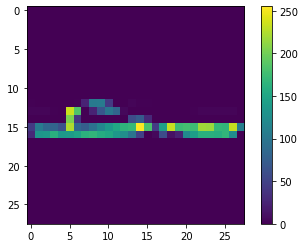

In [9]:
import random
a = random.randint(0,len(train_images))
plt.figure() #Crea una figura
plt.imshow(train_images[a])# muestra un input en formato RGB
plt.colorbar() #Barrita lateral
plt.grid(False)#No dibujes gradilla 
plt.show() #Muestra

Ese rango de 0 a 255 sale de la misma representación de los colores RGB, ya que cada color es representado por una cadena de 8 bits (RRGGBB), donde tenemos 2 bits para representar atributos de rojo, verde y azul individualmente, 28=250 contando el 0 tenemos de 0 a 255. Por ejemplo el color negro sería #000000.

Pero aún nos falta hacer algo más, tenemos que normalizar nuestro vector para que solo tome valores entre 0 y 1. Así que vamos a reasignar nuestras variables dividiendolas entre el valor más alto que pueden tomar, que en este caso es 255.

In [10]:
train_images = train_images / 255.0
test_images = test_images / 255.0

Para verificar que tenemos nuestros datos en el formato correcto y que están listos para entrenar a nuestra red, vamos a mostrar nuestras primeras 25 imágenes de nuestro set de entrenamiento y mostremos la clase que tienen asociada cada una:

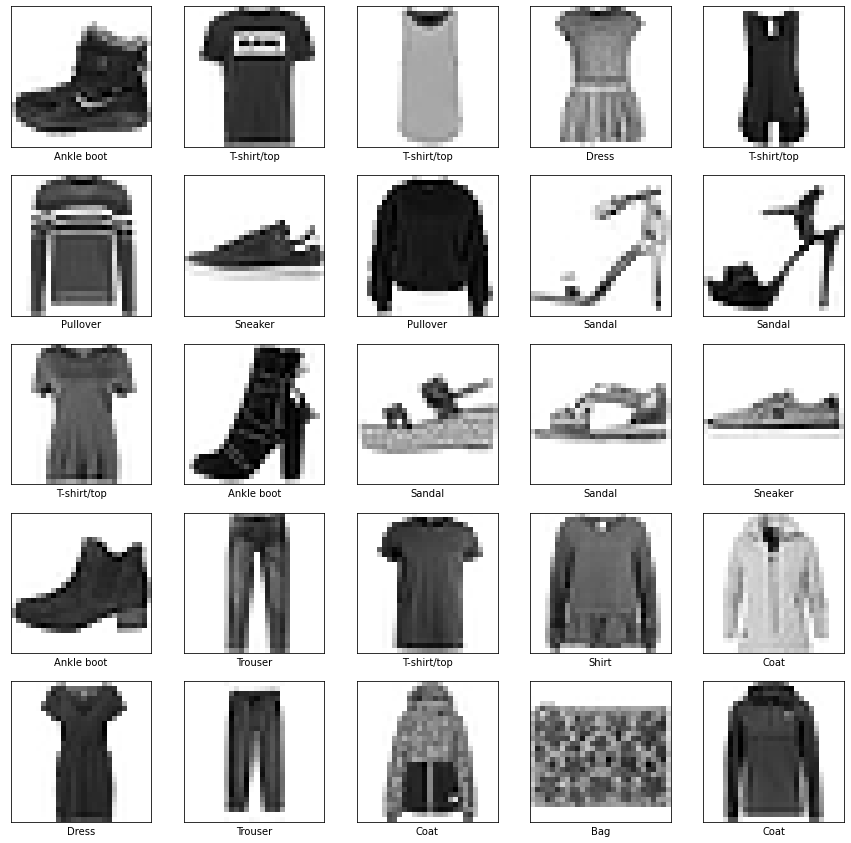

In [11]:
%matplotlib inline

plt.figure(figsize=(15,15))
for i in range(25):
    # Subplot ayuda a mostrar varías visualizaciones
    plt.subplot(5,5, i+1) #Crea una figurita en 5 filas x 5 columnas desde el elemento 1
    plt.xticks([]) #Espacios o posicionamientos en x
    plt.yticks([]) #Posicionamiento en y
    plt.grid(False)
    plt.imshow(train_images[i], cmap=plt.cm.binary)
    plt.xlabel(class_names[train_labels[i]])
plt.show()

### Creando el modelo

Para crear la red neuronal requerimos configurar las capas de nuestro modelo y después, compilar el modelo.

#### Configurando capas

El bloque fundamental al crear nuestra red neuronal son las capas. Estas capas extraen representaciones de los datos que hemos introducido en ellas. Con suerte, tendremos representaciones significativas para nuestro problema en cuestión.

La mayor parte del Deep Learning consiste en encadenar cadenas simples para poder extraer representaciones más complejas. La mayoría de capas, como tf.keras.layers.Dense, tienen parámetros que se van aprendiendo durante el entrenamiento.


In [12]:
model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=(28,28)),  #"Aplana" el input
    tf.keras.layers.Dense(128, activation='relu'), #Capa conectada que tiene una función de activación relu
    tf.keras.layers.Dense(10) #Capa de 10 unidades (SoftMax)               
])

La primera capa, tf.keras.layers.Flatten, transforma el formato de las imagenes de un arreglo bidimensional (28x28 píxeles) a un arreglo unidimensional (28×28=784

). Pensemos en esta capa como si estuvieramos acomodando nuestras filas para tener un único vector columna. Esta capa no tiene parámetros para aprender; soamente obtenemos los datos en un formato distinto.

Después de que los píxeles son "aplanados", la red neuronal consiste en una secuencia de 2 capas tf.keras.layers.Dense. Estas son capas neuronales densamente conectadas o completamente conectadas. El primer capa Dense tine 128 nodos (neuronas), mientras que la segunda devuelve una matriz logits con una longitud de 10 (Logits simplemente significa que la función opera en la salida sin escala de capas anteriores y que la escala relativa para comprender las unidades es lineal), esta segunda y última capa devuelve un arreglo de 10 probabilidades que suman a 1; cada nodo o neurona contiene un score que nos indica a cuál de las 10 clases pertenece nuestra imagen.


#### Compilando el modelo

Antes de que esté preparado para el entrenamiento, necesitamos hacerle una serie de configuraciones. Las añadiremos en nuestro paso de compilación donde tendremos:

* **Función de pérdida**: Esta parte mide que tan bueno es nuestro modelo durante el entrenamiento. Lo que queremos es minimizar la función de pérdida, de manera que "orientaremos" a nuestro modelo por el camino correcto.

* **Optimizador**: Esto es cómo el modelo será actualizado basado en los datos que va estudiando y en base a su función de pérdida, en este caso utilizaremos el optimizador `adam`.

* **Metrics**: Se utiliza para monitorizar los pasos de entrenamiento y de testeo. En el siguiente código vamos a utilizar `accuracy` que nos indica la fracción de las imágenes que ha sido clasificada correctamente.

In [13]:
model.compile(optimizer='adam',
             loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
             metrics=['accuracy'])

.SparseCategoricalCrossentropy() calcula la pérdida de entropía cruzada entre las etiquetas y las predicciones. Utilizamos esta función de pérdida de entropía cruzada cuando hay dos o más clases de etiquetas.

### Entrenando el modelo

Para entrenar a una red neuronal requeriremos de los siguientes pasos:

1. Ingresamos los datos de entrenamiento a nuestro modelo `training_images` y `training_labels`.

2. El modelo aprende a asociar las imágenes con sus etiquetas.

3. Le pedimos al modelo que haga predicciones, en este caso con nuestro set de testeo de imágenes `test_images`, obviamente sin etiquetas ya que eso queremos predecir.

4. Verificamos las predicciones comparandolas con nuestro conjunto `test_labels`.

In [14]:
# 1
model.fit(train_images, train_labels, epochs=10) # Epochs = iteraciones para que tenga mejor accuracy

Epoch 1/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.4965 - accuracy: 0.8260
Epoch 2/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.3712 - accuracy: 0.8668
Epoch 3/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.3354 - accuracy: 0.8778
Epoch 4/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.3112 - accuracy: 0.8858
Epoch 5/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.2943 - accuracy: 0.8913
Epoch 6/10
1875/1875 [==============================] - 3s 2ms/step - loss: 0.2783 - accuracy: 0.8965
Epoch 7/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.2672 - accuracy: 0.9006
Epoch 8/10
1875/1875 [==============================] - 3s 2ms/step - loss: 0.2560 - accuracy: 0.9044
Epoch 9/10
1875/1875 [==============================] - 3s 2ms/step - loss: 0.2477 - accuracy: 0.9074
Epoch 10/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.237

En este caso nuestro modelo tiene un accuracy de 91%
en base a nuestros datos de entrenamiento.

In [15]:
# 2
# Comparemos que tan bien hace predicciones

test_loss, test_acc = model.evaluate(test_images, test_labels, verbose=2)
print(f'\nTest accuracy: {round(test_acc,3)}\nTest Loss: {round(test_loss, 3)}')

313/313 - 0s - loss: 0.3289 - accuracy: 0.8874

Test accuracy: 0.887
Test Loss: 0.329


Podemos ver que el accuracy esta vez es un poco menor que el que obtuvimos con los datos de entrenamiento. Esta brecha entre el accuracy de entrenamiento y el test es un claro ejemplo de sobre ajuste.


### Predicciones del modelo

Con el modelo ya entrenado, podemos utilizarlo para hacer algunas predicciones con nuevas imágenes. Las salidas lineales del modelo, `logits`.

> `logit`: Vector de predicciones sin procesar (no normalizadas) que genera un modelo de clasificación, que comúnmente se pasa a una función de normalización. Si el modelo está resolviendo un problema de clasificación de clases múltiples, los logits generalmente se convierten en una entrada para el atributo de softmax, que luego genera un vector de probabilidades (normalizadas) con un valor para cada clase posible.

 Podemos adjuntar una capa `softmax` para convertir los `logits` en probabilidades, las cuales son más faciles de interpretar:

In [19]:
probability_model = tf.keras.Sequential([model,
                                         tf.keras.layers.Softmax()])

In [20]:
predictions = probability_model.predict(test_images)
predictions =  predictions.round(4)

In [21]:
import pandas as pd
predict_df = pd.DataFrame(predictions)
predict_df

0       1       2       3  ...       6       7       8       9
0     0.0000  0.0000  0.0000  0.0000  ...  0.0000  0.0157  0.0000  0.9838
1     0.0002  0.0000  0.9985  0.0000  ...  0.0002  0.0000  0.0000  0.0000
2     0.0000  1.0000  0.0000  0.0000  ...  0.0000  0.0000  0.0000  0.0000
3     0.0000  1.0000  0.0000  0.0000  ...  0.0000  0.0000  0.0000  0.0000
4     0.0656  0.0000  0.0251  0.0132  ...  0.8840  0.0000  0.0001  0.0000
...      ...     ...     ...     ...  ...     ...     ...     ...     ...
9995  0.0000  0.0000  0.0000  0.0000  ...  0.0000  0.0001  0.0000  0.9999
9996  0.0000  0.9998  0.0000  0.0002  ...  0.0000  0.0000  0.0000  0.0000
9997  0.0000  0.0000  0.0000  0.0000  ...  0.0000  0.0000  1.0000  0.0000
9998  0.0000  1.0000  0.0000  0.0000  ...  0.0000  0.0000  0.0000  0.0000
9999  0.0000  0.0000  0.0000  0.0000  ...  0.0000  0.0006  0.0000  0.0000

[10000 rows x 10 columns]

Podemos ver que las predicciones son arrays de 10 números. Y en el Data Frame de arriba podemos ver un poco más claro como el modelo asignó cierta probabilidad de que el elemento perteneciera a cada una de las posibles clases (recordemos que están de 0 a 9).

Podemos verificar cuál es la etiqueta con el valor más alto y por lo tanto, la etiqueta en donde clasificó dicho objeto:


In [22]:
np.argmax(predictions[0])

9

Correspondiente a la última columna, la cuál era `'Ankle boot'
`. Si lo revisamos con nuestra etiqueta del set de test, `test_labels` podremos ver que hizó la clasificación correcta:

In [23]:
test_labels[0]

9

Vamos a construir nuestras funciones para gráficar nuestras predicciones:


In [24]:
# Dibuja una imagen, recibe el indice de la imagen, la etiqueta predicha (más bien su vector completo),
# la etiqueta real y el set de imágenes para después tomar la imagen de indice "i".
def plot_image(i, predictions_array, true_label, img):

    # De las etiquetas de test obten la de indice i, lo mismo con las imágenes
    true_label, img = true_label[i], img[i]

    # Estos pasos ya los conocemos
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(img, cmap=plt.cm.binary)

    # Obtenemos el valor con la probabilidad más alta
    predicted_label = np.argmax(predictions_array)

    if predicted_label == true_label:
        color = 'blue' # Azul si acertó el modelo
    else: 
        color = 'red'  # Rojo si falló
    
    plt.xlabel("{} {:2.0f}% ({})".format(class_names[predicted_label], #Primero la etiqueta predicha
                                         100*np.max(predictions_array), # Porcentaje obtenido
                                         class_names[true_label]), # Etiqueta real
                                         color = color) # Color si acertó o falló

In [25]:
# Dibuja el array, toma el indice, el array de predicciones y la etiqueta correcta
def plot_value_array(i, predictions_array, true_label):

    # Ubica la etiqueta real
    true_label = true_label[i]

    # Desactiva la gradilla y ubica los elementos 
    plt.grid(False)
    plt.xticks(range(10))
    plt.yticks([])

    # Haz una gráfica de barras de 0 a 9 con nuestras predicciones de color gris
    this_plot = plt.bar(range(10), predictions_array, color="#777777")
    plt.ylim( [0,1] ) # Ya que está normalizado

    # Ubica el valor predicho
    predicted_label = np.argmax(predictions_array)

    # Valor predicho con rojo
    this_plot[predicted_label].set_color('red')
    # Valor real con azul
    this_plot[true_label].set_color('blue')

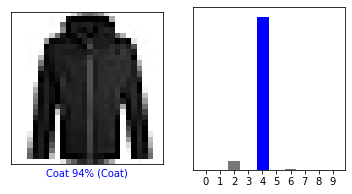

In [26]:
import random
i = random.randint(0, len(predictions))
plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
plot_image(i, predictions[i], test_labels, test_images)
plt.subplot(1,2,2)
plot_value_array(i, predictions[i],  test_labels)
plt.show()

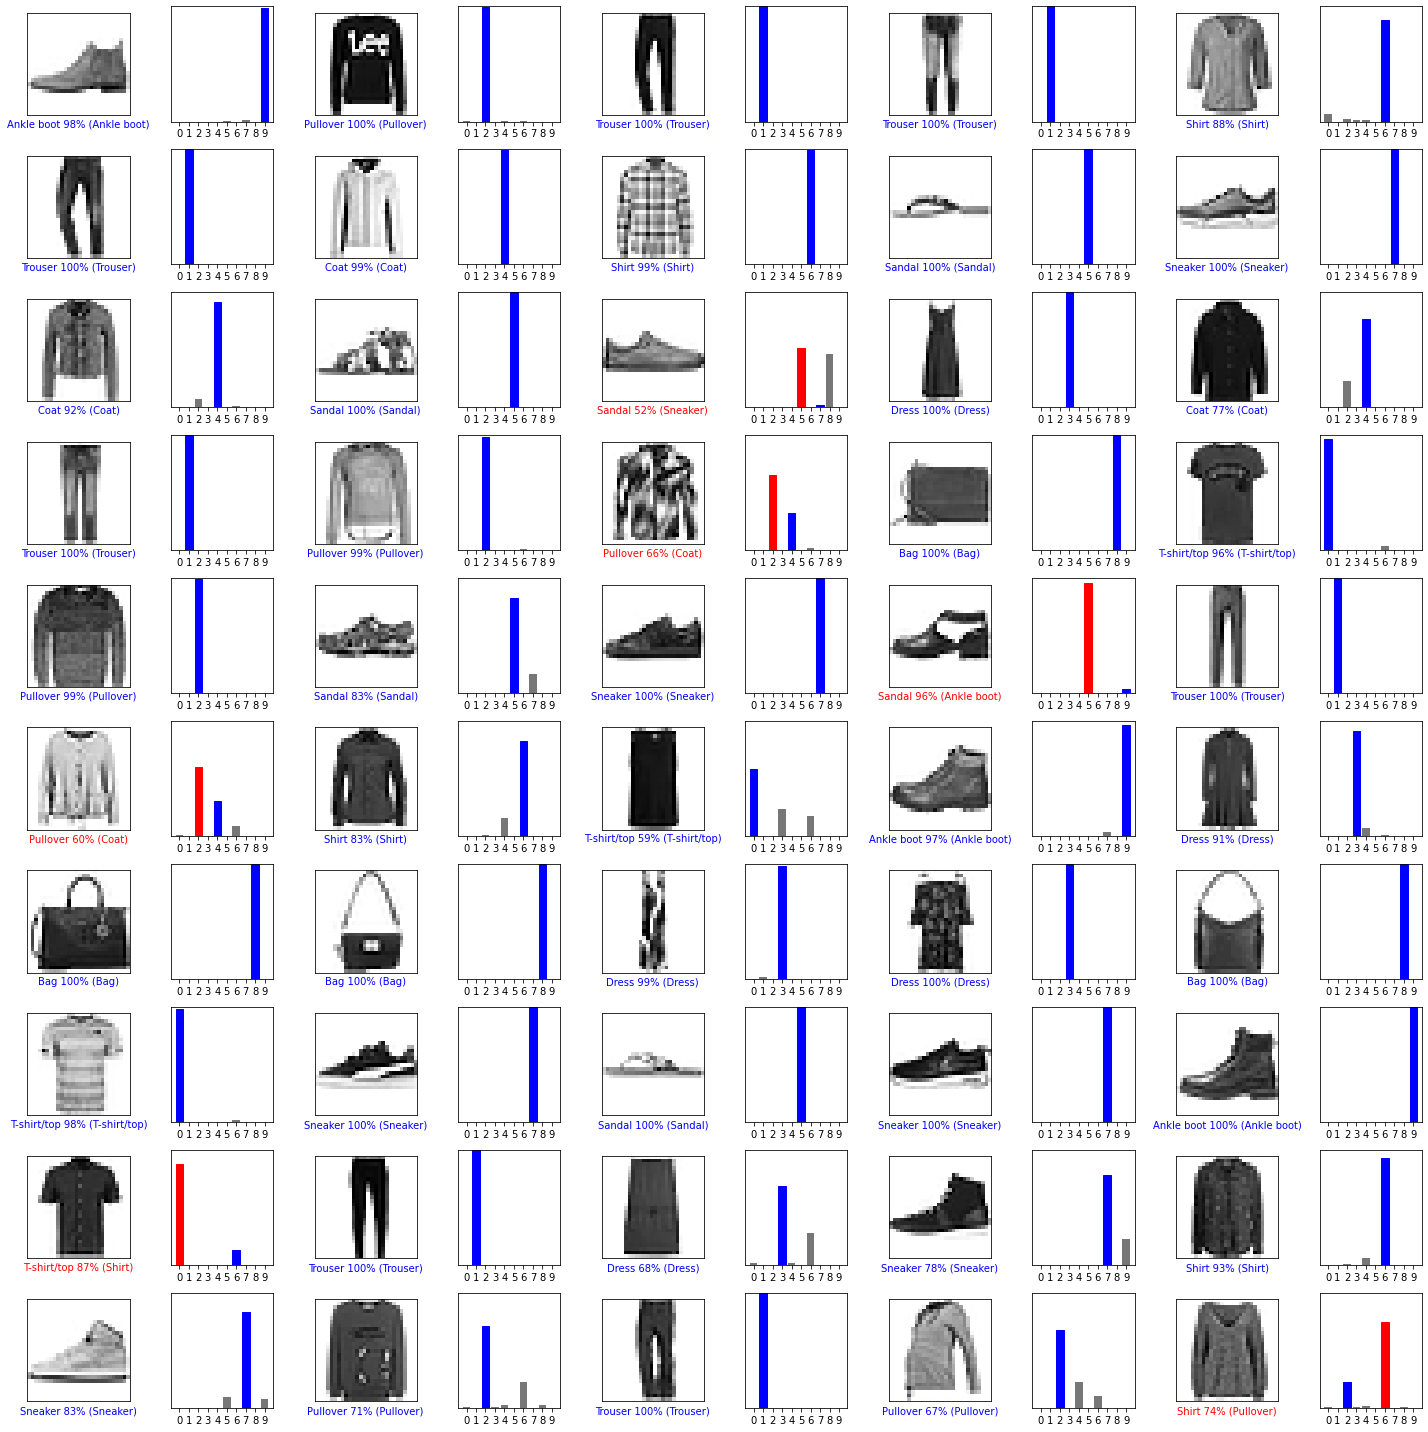

In [27]:
num_rows = 10
num_cols = 5
num_images = num_rows*num_cols
plt.figure(figsize=(2*2*num_cols, 2*num_rows))
for i in range(num_images):
  plt.subplot(num_rows, 2*num_cols, 2*i+1)
  plot_image(i, predictions[i], test_labels, test_images)
  plt.subplot(num_rows, 2*num_cols, 2*i+2)
  plot_value_array(i, predictions[i], test_labels)
plt.tight_layout()
plt.show()

---